
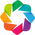

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import holoviews as hv

from spykshrk.realtime.simulator import nspike_data

from spykshrk.franklab.pp_decoder.pp_clusterless import OfflinePPDecoder
from spykshrk.franklab.data_containers import EncodeSettings, DecodeSettings, SpikeObservation, \
                                              LinearPosition, StimLockout, Posteriors
from spykshrk.franklab.pp_decoder.visualization import DecodeVisualizer

%load_ext Cython

%matplotlib inline

#pd.set_option('float_format', '{:,.2f}'.format)
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)
#pd.set_option('display.width', 180)

hv.extension('bokeh')

idx = pd.IndexSlice


In [2]:
# Load config file and data

config_file = '/home/daliu/Src/spykshrk_realtime/config/bond_single.json'
config = json.load(open(config_file, 'r'))
day = config['simulator']['nspike_animal_info']['days'][0]
epoch = config['simulator']['nspike_animal_info']['epochs'][0]

# Main hdf5 data source file name
hdf_file = os.path.join(config['files']['output_dir'],
                        '{}.rec_merged.h5'.format(config['files']['prefix']))

# Extract just encode and decode settings from config
encode_settings = EncodeSettings(config)
decode_settings = DecodeSettings(config)

# Open data file
store = pd.HDFStore(hdf_file, mode='r')

# Encapsulate Spike Observation panda table in container
observ_obj = SpikeObservation.from_realtime(store['rec_3'], day=day, epoch=epoch, enc_settings=encode_settings)

# Grab stimulation lockout times
stim_lockout = StimLockout.from_realtime(store['rec_11'], enc_settings=encode_settings)

# Grab animal linearized real position
nspike_anim = nspike_data.AnimalInfo(**config['simulator']['nspike_animal_info'])
pos = nspike_data.PosMatDataStream(nspike_anim)
pos_data = pos.data

# Encapsulate linear position
lin_obj = LinearPosition.from_nspike_posmat(pos_data, encode_settings)

In [3]:
lin_obj._metadata

['kwds', 'history', 'sampling_rate', 'arm_coord']

In [4]:
# Linearized position data, example of MultiIndexing pandas table
lin_obj

<LinearPosition: cf0bd0d8-753a-4c79-9588-c9857f1a7275, shape: ((28290, 7))>

In [5]:
# Up sampling position data to 30 samples/bin, using backfill to interpolate
lin_obj.get_resampled(30)

<LinearPosition: 04996ca1-1292-416a-a912-831648144b33, shape: ((943968, 8))>

In [6]:
# Down sampling position data to 30000 samples/bin, dropping data points
lin_obj.get_resampled(30000)

<LinearPosition: bc67d67a-6846-4a48-9c6d-c72ba37b838b, shape: ((943, 8))>

In [7]:
# Observation distribution of each spike in a single epoch. This is calculated and cached from 
# an encoding model in the realtime module. Currently this is only valid for a single epoch's data.

observ_obj

<SpikeObservation: 42fc35c7-f30d-42de-9ce6-89e4f9c54760, shape: ((303111, 455))>

In [8]:
# Assign bins (300 samples == 10ms) to each spike based on its timestamp, bins stored as dec_bin column.

observ_obj.update_observations_bins(300)

<NewCls: aa7a60da-fe31-4aed-adcb-03e005db35c2, shape: ((303111, 458))>

In [9]:
# For each time bin, compute the product of the distribution stored in columns x0:x449.
# This estimates the probability distribution of position at each time bin. Refer to 
# spykshrk.franklab.pp_decoder.pp_clusterless.OfflinePPDecoder.calc_observation_intensity
# for analysis code that uses groupby.

spike_decode = observ_obj.update_observations_bins(3000)
groups = spike_decode.groupby('dec_bin')

def prod_dist(df):
    norm_prod = np.ones(450)
    for ind, row in zip(df.index, df.loc[:,'x000':'x449'].values):
        norm_prod = norm_prod * row
        norm_prod = norm_prod / norm_prod.sum()
    prod_ser = pd.Series(norm_prod, index=['x{:03d}'.format(bin_id) for bin_id in range(450)])
    prod_ser['day'] = ind[0]
    prod_ser['epoch'] = ind[1]
    prod_ser['timestamp'] = df['dec_bin_start'].iloc[0]
    prod_ser['time'] = df['dec_bin_start'].iloc[0] / 30000

    return prod_ser

observ_binned = groups.apply(prod_dist)

observ_binned.set_index(['day', 'epoch', 'timestamp', 'time'], inplace=True)

post = Posteriors.from_dataframe(observ_binned, history=spike_decode.history)

In [10]:
lin_obj.get_mapped_single_axis()

<FlatLinearPosition: 874857a2-1e63-4d8a-85b6-f9f1ae9c03d4, shape: ((28290, 3))>

In [11]:
# Convert linearized position segments onto a single axis to match the decoded position mapping.
# This function uses the query command of Panda dataframes.
# e.g.:
# right_pos_flat = (self.pos_data.query('@self.pos_data.seg_idx.seg_idx == 4 | '
#                                       '@self.pos_data.seg_idx.seg_idx == 5').
#                   loc[:, ('lin_dist_well', 'well_right')]) + self.arm_coord[2][0]

single_axis_lin_pos = lin_obj.get_resampled(3000).get_mapped_single_axis()

In [12]:
# Display the copy history of this LinearPosition object, starting from the first instantiation

single_axis_lin_pos.history

[                                lin_dist_well                          lin_vel                      seg_idx
                                   well_center well_left well_right well_center well_left well_right seg_idx
 day epoch timestamp     time                                                                               
 4.0 1.0   73,830,339.0  2,461.0          27.8     142.1      144.5         7.5     134.4      136.4     1.0
           73,831,341.0  2,461.0          26.9     143.0      145.4         7.5     134.4      136.4     1.0
           73,832,343.0  2,461.1          25.5     144.3      146.8         6.7     134.5      136.6     1.0
           73,833,342.0  2,461.1          24.6     145.2      147.7         5.8     134.1      136.1     1.0
           73,834,344.0  2,461.1          23.3     146.6      149.0         4.9     133.2      135.1     1.0
 ...                                       ...       ...        ...         ...       ...        ...     ...
           102,145,

In [13]:
# Get stim lockout ranges from digital output state

stim_lockout

<StimLockout: b359344c-4043-4ba7-b2e4-874c4215b404, shape: ((191, 4))>

In [14]:
%%output backend='bokeh' size=400 holomap='scrubber'
%%opts RGB { +framewise} [height=100 width=250 colorbar=True]
%%opts Points {+framewise} [height=100 width=250] (marker='o' size=4 alpha=0.5)

dec_viz = DecodeVisualizer(post, linpos=lin_obj, enc_settings=encode_settings)

dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=10, slide=10)


:DynamicMap   [time]